## Модели ARIMA и GARCH

Данные для лекции выложены в [репозитории](https://github.com/netology-code/ds3-spring-2018/tree/master/7.%20Time_series/7.3/Series) GitHub или на [гугл-диске](https://drive.google.com/open?id=1ZE6MsXuzPh-dbugsAV-8Ywu9fCC688WG)

In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

## В чем суть

Будем представлять временной ряд $y_t$ в виде

$y_t = T + S + E$

где T - тренд, S - сезонная компонента, E - ошибка прогноза

Будем рассматривать разные "порождающие" модели для рядов. Интуитивно - если ряд хорошо описывается моделью, то остатки - независимые и одинаково распределенные

# AR(p)

Авторегрессионная модель — модель временных рядов, в которой значения временного ряда в данный момент линейно зависят от предыдущих значений этого же ряда. Авторегрессионный процесс порядка p (AR(p)-процесс) определяется следующим образом

$y_t = c + \sum_{i=1}^P a_i y_{t-i} + \epsilon_t$

где $\epsilon_t$ - белый шум

### Индекс Доу-Джонса

In [5]:
series = pd.read_csv("weekly-closings-of-the-dowjones-.csv", sep=";")['Count']

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


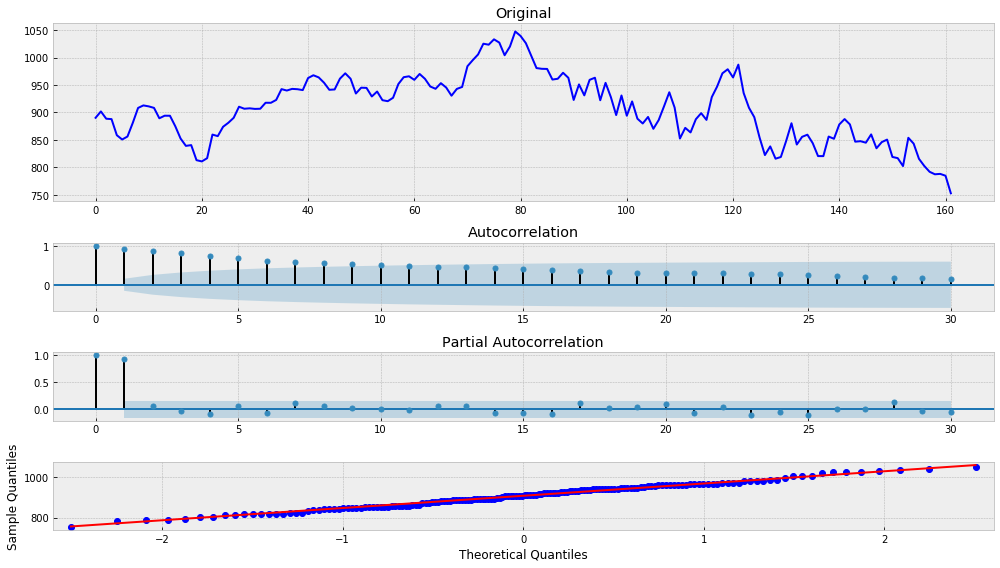

In [6]:
 tsplot(series, lags=30)

In [7]:
mdl = smt.AR(series.values).fit(maxlag=30, ic='aic', trend='nc')
print(mdl.params)

[0.99891618]


### Продажи домов

In [8]:
series_2 = pd.read_csv("sales-of-new-onefamily-houses-us.csv", sep=";")['Count']

Results of Dickey-Fuller Test:
Test Statistic                 -1.269234
p-value                         0.643128
#Lags Used                     12.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


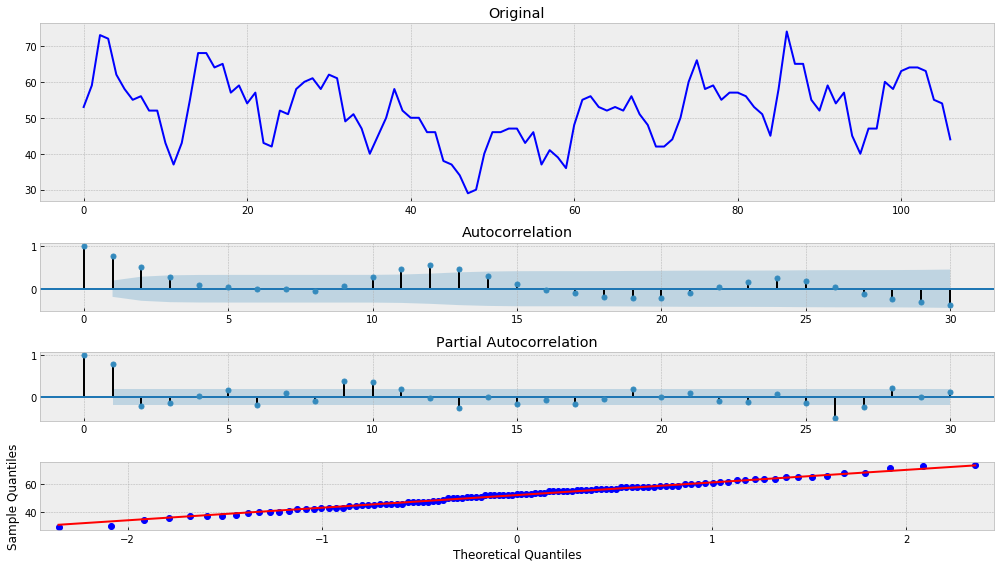

In [9]:
 tsplot(series_2, lags=30)

In [10]:
mdl = smt.AR(series_2.values).fit(maxlag=30, ic='aic', trend='nc')
print(mdl.params)

[ 0.78071341  0.04840459  0.0574271  -0.24384153  0.17529095 -0.11369432
  0.22850301 -0.22168503 -0.05548682  0.20966962  0.15744466  0.26342624
 -0.28609369]


## MA(q)
В настоящий момент будем говорить про модель MA(q) - как про модель авторегресии на случайном шуме

$y_t = \sum_{j=0}^{Q} b_j \epsilon_{t-j}$

## ARMA(p,q)

Модель ARMA(p, q) представляет собой соединение двух моделей:
- AR(P) - авторегрессии на знанениях временного ряда
- MA(q) - авторегрессии на ошибках первой

AR(p) пытается предсказать "значение" временного ряда, а MA(q) пытается поймать шоковые явления, наблюдаемые в оставшемся случайном шуме.

$y_t = \sum_{i=1}^P a_i x_{t-i} + \sum_{i=1}^Q b_i \epsilon_{t-i} + \epsilon_t + c$

p, q - гипер параметры => их можно подбирать. Как выбрать лучшие? AIC - Информационный критерий Акаике

Применим модель ARMA к ряду по продаже домов

Results of Dickey-Fuller Test:
Test Statistic                 -3.414319
p-value                         0.010480
#Lags Used                     12.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


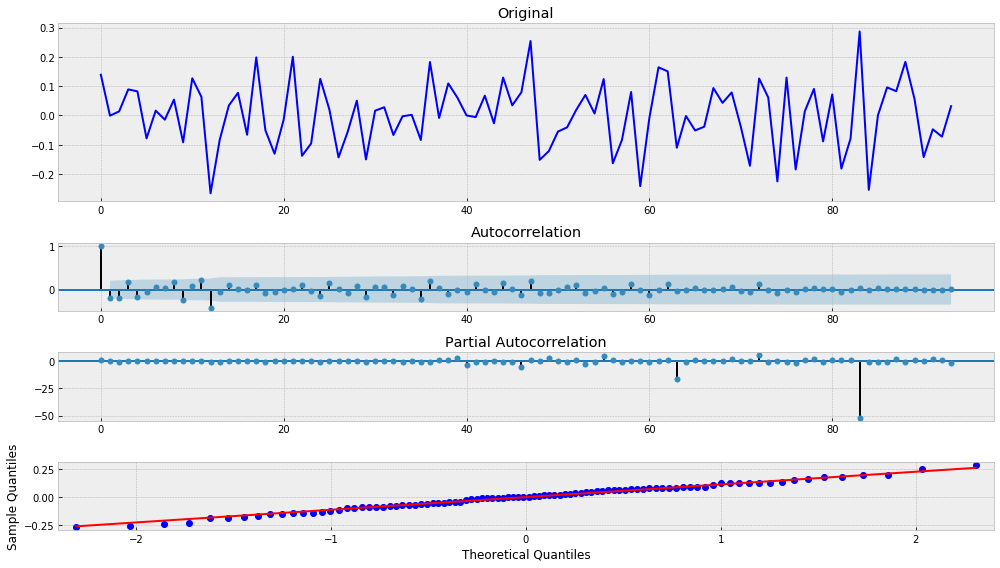

In [11]:
series_2 = boxcox(series_2, 0)
series_2 = series_2[12:] - series_2[:-12]
series_2 = series_2[1:] - series_2[:-1]
tsplot(series_2)

In [12]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(10):
    for j in range(10):
        try:
            tmp_mdl = smt.ARMA(series_2, order=(i, j)).fit(
                method='mle', trend='nc'
            )
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
            print('aic: {:6.5f} | order: {}'.format(aic, order))
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\

aic: -164.28288 | order: (9, 8)


C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Results of Dickey-Fuller Test:
Test Statistic                -9.568661e+00
p-value                        2.319951e-16
#Lags Used                     0.000000e+00
Number of Observations Used    9.300000e+01
Critical Value (1%)           -3.502705e+00
Critical Value (5%)           -2.893158e+00
Critical Value (10%)          -2.583637e+00
dtype: float64


C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


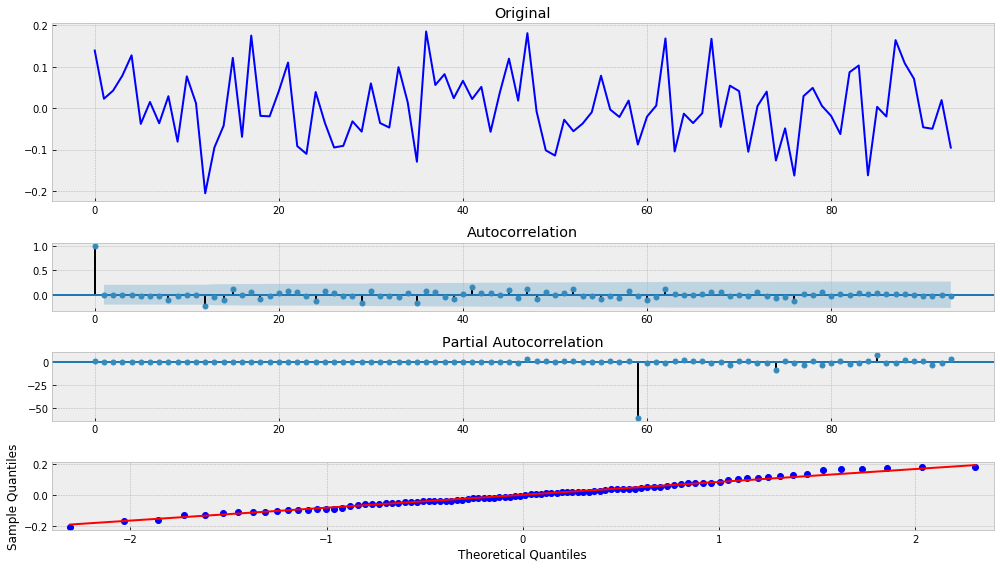

In [13]:
mdl = smt.ARMA(series_2, order=(9, 8)).fit(
                method='mle', trend='nc'
            )
tsplot(mdl.resid)

## ARIMA (p,d,q)

ARIMA - естественное расширение модели ARMA. Как мы уже хорошо знаем - многие временные ряды не стационарны, но они могут такими стать в результате операции дифференцирования. В модели ARIMA "дифференцирование" (в количестве d-раз) вносится в саму модель


$\delta^p y_t = c + \sum_{i=1}^p a_i \delta^d y_{t-i} + \sum_{j=1}^q b_j \epsilon_{t-j} + \epsilon_t$

C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alexe\Anaco

aic: -155.31325 | order: (2, 0, 4)
Results of Dickey-Fuller Test:
Test Statistic                 -3.681511
p-value                         0.004381
#Lags Used                     11.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


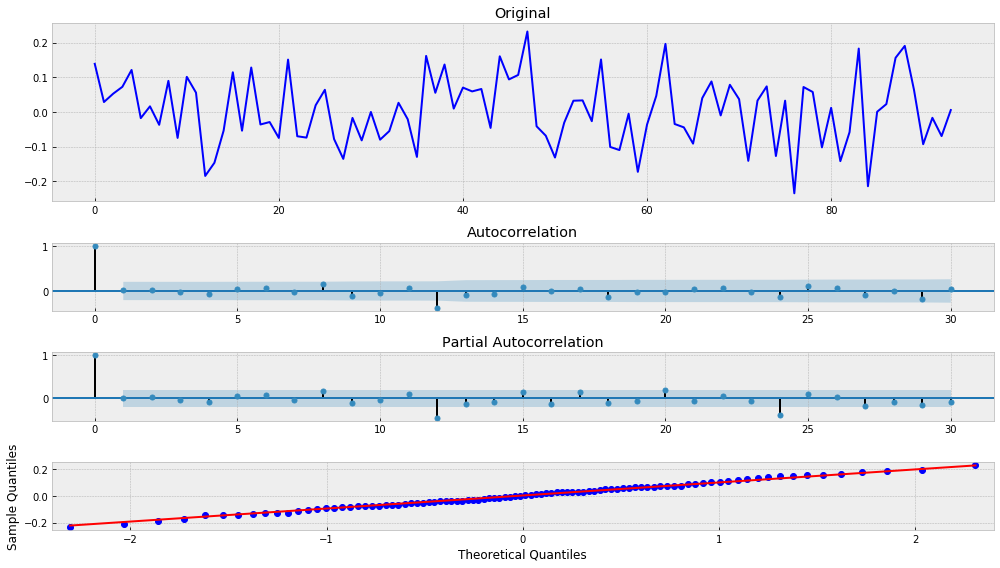

In [14]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series_2, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

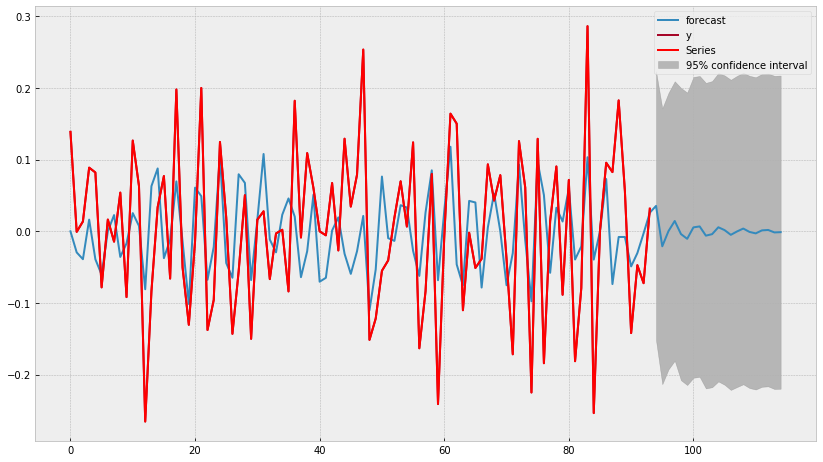

In [15]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(0, len(series_2)+20, ax=ax)
    plt.plot(series_2, color='red', label='Series')
    plt.legend()
    plt.show()

Другие вариации для класса ARMA:
- SARIMA - арима с учетом сезонности
- ARIMAX/SARIMAX

## ARCH

AutoRegressive Conditional Heteroscedasticit - пытаемся объяснить дисперсию в ряде через предыдущие значения (применяя к ним AR)

Пусть временной ряд представляется в таком виде:

$u_t = \epsilon_t * \sqrt{\alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2}$

Тогда условная дисперсия ряда будет равна

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2$

Получили модель ARCH(q) условной дисперсии. Требуем, чтобы все коэффициенты были больше 0 (иначе может получится отрицательная дисперсия)

## GARCH

Добавляем зависимость от прошлых значений самой условной дисперсии. Получаем модель GARCH(p, q)

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2$

GARCH - по сути - модель ARMA примененная к дисперсии ряда

In [16]:
from arch import arch_model

Применим ARIMA к индексу Доу-Джонса

In [17]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(10):
        for d in range(10):
            for j in range(10):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

aic, order, mdl = _get_best_model(series)

C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:649: RuntimeWarning: divide by zero encountered in true_divide
  R_mat, T_mat)
C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\alexe\Anaconda3\lib\site-packages\statsm

C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInver

aic: 1416.27670 | order: (2, 2, 3)


Results of Dickey-Fuller Test:
Test Statistic                -1.184572e+01
p-value                        7.407981e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.590000e+02
Critical Value (1%)           -3.472161e+00
Critical Value (5%)           -2.879895e+00
Critical Value (10%)          -2.576557e+00
dtype: float64


C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


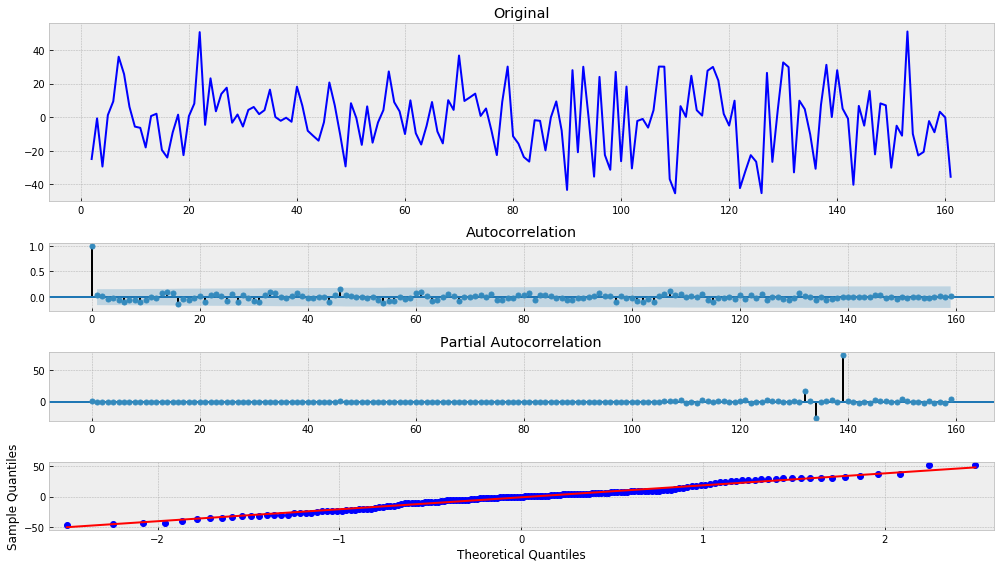

In [18]:
tsplot(mdl.resid)

Применим GARCH для продажи домов

In [19]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                        Count   R-squared:                      -0.002
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.002
Vol Model:                        GJR-GARCH   Log-Likelihood:               -853.619
Distribution:      Standardized Student's t   AIC:                           1727.24
Method:                  Maximum Likelihood   BIC:                           1758.11
                                              No. Observations:                  162
Date:                      Sun, Aug 05 2018   Df Residuals:                      152
Time:                              13:39:13   Df Model:                           10
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


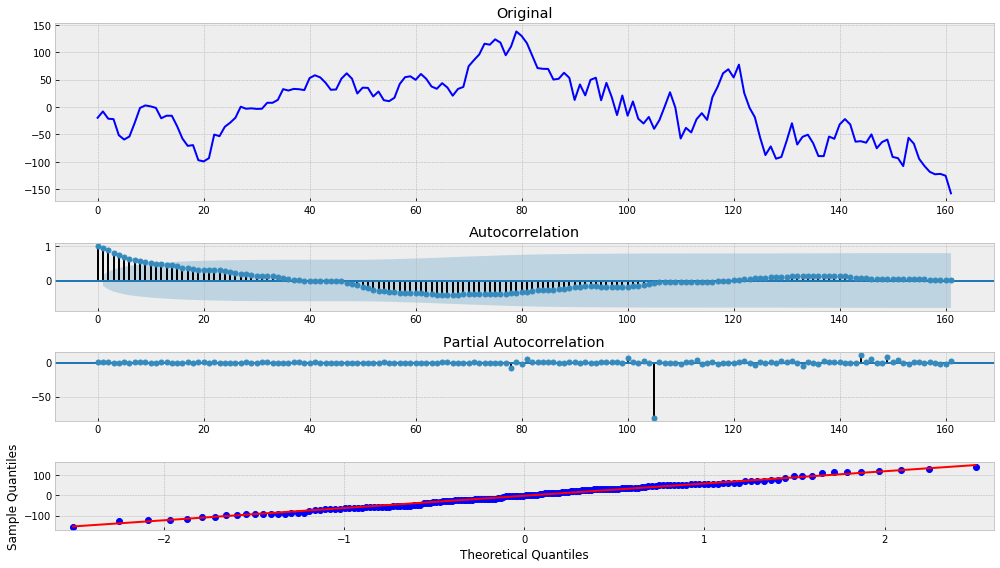

In [20]:
tsplot(res.resid)

## Проведем анализ для продажи домой

In [21]:
min(series_2)

-0.2655511553960106

In [22]:
for i in range(len(series_2)):
    series_2[i]=series_2[i]+1

In [23]:
min(series_2)

0.7344488446039894

Results of Dickey-Fuller Test:
Test Statistic                 -3.717506
p-value                         0.003874
#Lags Used                     10.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


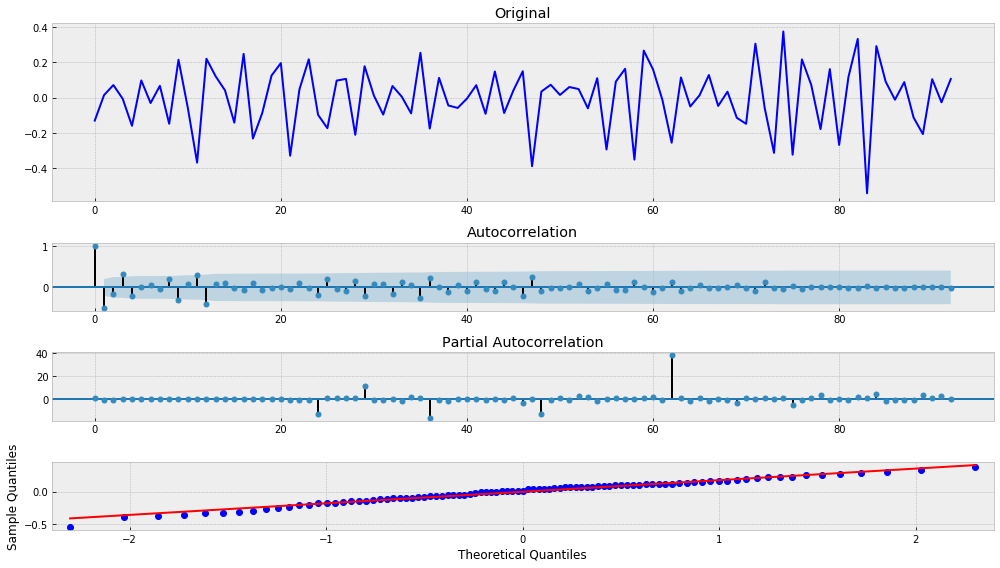

In [24]:
new_series = series_2
new_series = boxcox(new_series, 0)
new_series = new_series[1:] - new_series[:-1]
tsplot(new_series)

In [25]:
aic, order, mdl = _get_best_model(new_series)


C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:649: RuntimeWarning: divide by zero encountered in true_divide
  R_mat, T_mat)
C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\alexe\Anaconda3\lib\site-packages\statsm

C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInver

aic: 1416.27670 | order: (2, 2, 3)


Results of Dickey-Fuller Test:
Test Statistic                -1.184572e+01
p-value                        7.407981e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.590000e+02
Critical Value (1%)           -3.472161e+00
Critical Value (5%)           -2.879895e+00
Critical Value (10%)          -2.576557e+00
dtype: float64


C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


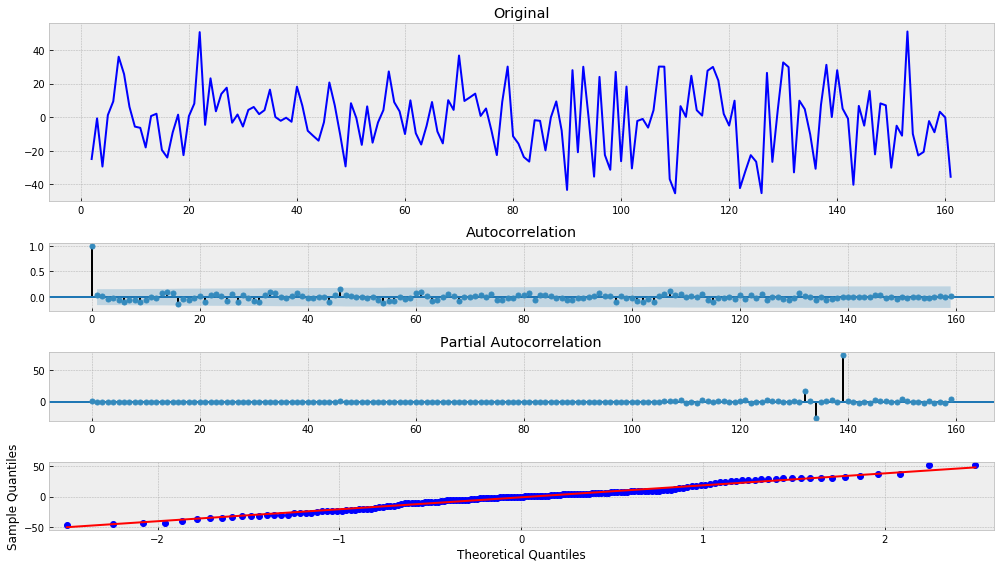

In [26]:
tsplot(mdl.resid)

In [27]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(new_series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     69,   Neg. LLF: -31.777906012268954
Iteration:     10,   Func. Count:    132,   Neg. LLF: -33.21816458090301
Iteration:     15,   Func. Count:    192,   Neg. LLF: -33.49454485913462
Iteration:     20,   Func. Count:    252,   Neg. LLF: -33.984936066290366
Iteration:     25,   Func. Count:    312,   Neg. LLF: -34.11804207221722
Iteration:     30,   Func. Count:    383,   Neg. LLF: -34.14011254104701
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -34.14011254097735
            Iterations: 30
            Function evaluations: 394
            Gradient evaluations: 30
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                      -0.006
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.006
Vol Model:                        GJR-GARCH   Log-Likelihood:                34.1401
Distribu

Results of Dickey-Fuller Test:
Test Statistic                 -3.717506
p-value                         0.003874
#Lags Used                     10.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


C:\Users\alexe\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


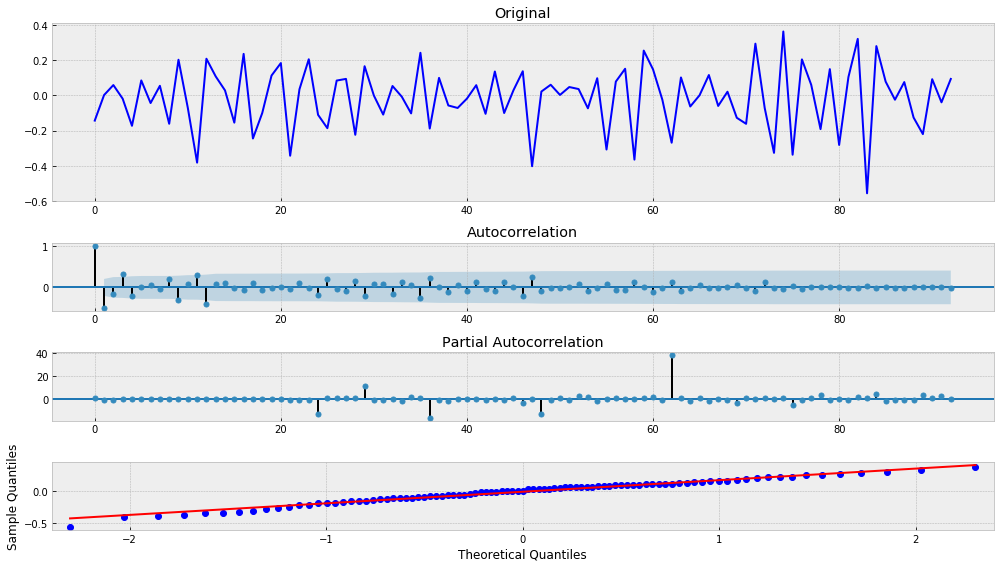

In [28]:
tsplot(res.resid)

## Полезная информация
- https://people.duke.edu/~rnau/411home.htm
- https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-276
- http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016